# Data Loading and Exploration

In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import pylab as pl
import requests

In [2]:
borough = 'M'
boroughs = {'M': '1',  # Manhattan
            '?': '2',  # Bronx
            '?': '3',  # Brooklyn
            '?': '4',  # Queens
            '?': '5'}  # Staten Island
borough_names = {'M': 'Manhattan',
                 '?': 'Bronx',
                 '?': 'Brooklyn',
                 '?': 'Queens',
                 '?': 'Staten Island'}

# missing boroughs are: {'B', 'Q', 'R', 'X'}

In [3]:
def angular_distance(lon1, lat1, lon2, lat2):
    """
    Angular distance between 2 points, all arguments in rad.
    """
    return pl.arccos(pl.sin(lat1)*pl.sin(lat2)+pl.cos(lat1)*pl.cos(lat2)*pl.cos(lon2-lon1))


def rad_to_deg(x):
    """
    Conversion from radian to degree
    """
    return x*180./pl.pi


def deg_to_rad(x):
    """
    Conversion from radian to degree
    """
    return x*pl.pi/180.

# Data Loading

In [4]:
print('Loading park zone data')
df1 = gpd.read_file('raw_data/Parks Zones.geojson')
print('Loading sidewalk data')
df2 = gpd.read_file('raw_data/Sidewalk Centerline.geojson')
print('Loading street data')
df3 = gpd.read_file('raw_data/NYC Street Centerline (CSCL).geojson')
# use API, database too big
#print('Loading tree data')
#df4 = gpd.read_file('raw_data/2015 Street Tree Census - Tree Data.geojson')
print('Done')

Loading park zone data
Loading sidewalk data
Loading street data
Done


In [5]:
# download trees from SODA API (https://dev.socrata.com/consumers/getting-started.html)
# see https://dev.socrata.com/docs/queries/offset.html for how to offset and get the whole list
query_limit = 25000  # absolute limit is 50 000
request = 'https://data.cityofnewyork.us/resource/5rq2-4hqu.json?boroname={0:s}&$limit={1:d}'.format(borough_names[borough], query_limit)
r = requests.get(request)
text = r.text[:-1]

In [6]:
import ast
#t concert string to list of dictionary safely
tree_list = ast.literal_eval(text)
if len(tree_list) == query_limit:
    print('Warning: number of trees returned {0:d} is the same as the limit {1:d}'.format(len(tree_list), query_limit))
    print('You are likely missing some trees...')
# convert to DataFrame
borough_df4 = pd.DataFrame(tree_list)
# write data to file
borough_df4.to_csv('raw_data/Tree_{0:s}.csv'.format(borough))
borough_df4.head()
#borough_df4.iloc[0]

You are likely missing some trees...


,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,...,tree_dbh,tree_id,trnk_light,trnk_other,trnk_wire,user_type,x_sp,y_sp,zip_city,zipcode
0,8 COLUMBUS AVENUE,106099,1014500,1,Manhattan,No,No,No,107,3,...,11,190422,No,No,No,Volunteer,988418.699656,219825.522669,New York,10023
1,120 WEST 60 STREET,106099,1014500,1,Manhattan,No,No,No,107,3,...,11,190426,No,No,No,Volunteer,988311.190028,219885.278455,New York,10023
2,311 WEST 50 STREET,103940,1012700,1,Manhattan,No,No,No,104,3,...,9,208649,No,No,No,Volunteer,987769.116309,217157.856088,New York,10019
3,170 EAST 75 STREET,107600,1012800,1,Manhattan,No,Yes,No,108,4,...,14,193310,No,Yes,No,Volunteer,995203.003673,220602.155302,New York,10021
4,2163 BROADWAY,107038,1016300,1,Manhattan,No,No,No,107,6,...,4,199760,No,No,No,TreesCount Staff,989521.741413,224212.887582,New York,10024


In [7]:
#borough_df4['longitude'] = pd.to_numeric(borough_df4['longitude'].to_numeric()
borough_df4[['longitude', 'latitude']] = borough_df4[['longitude', 'latitude']].astype(float)
#borough_df4['longitude'].iloc[0]
#print(borough_df4['longitude'])
#borough_df4.plot('longitude', 'latitude', kind='scatter')

#print(borough_df4['the_geom'].iloc[0])
#print(df3['geometry'].iloc[0])
df3.iloc[0]

rw_type                                                       6
l_low_hn                                                   None
pre_direct                                                 None
st_width                                                      0
r_zip                                                     10458
r_low_hn                                                   None
bike_lane                                                  None
post_type                                                   TRL
r_blkfc_id                                                    0
bike_trafd                                                 None
frm_lvl_co                                                   13
post_modif                                                 None
pre_type                                                   None
full_stree                          MITSUBISHI WILD WETLAND TRL
l_blkfc_id                                                    0
shape_leng                              

## Select data by Borough

In [8]:
# selecting Manhattan
borough_df1 = df1.loc[df1['borough'] == borough]

In [9]:
borough_df2 = df2

In [10]:
# boroughs are {}'1', '2', '3', '4', '5', '6'}
# selecting Manhattan
borough_df3 = df3.loc[df3['borocode'] == boroughs[borough]]

## Plotting Borough Data

Text(0.5,1,'NYC Map of Running Areas')

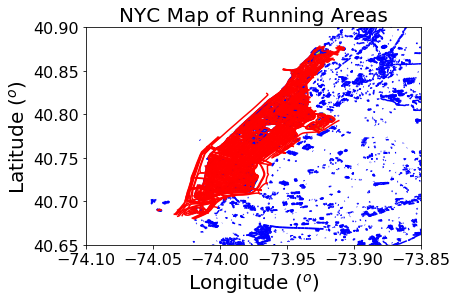

In [11]:
fig, ax1 = pl.subplots()#figsize=(12, 12))
borough_df1.plot(ax=ax1, color='y', label='x')  # roads
borough_df2.plot(ax=ax1, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax1, color='r', label='z')  # parks

# to do: remove data outside of proper borough
x_range = [-74.05, -73.9]
y_range = [40.65, 40.9]
x0 = pl.mean(x_range)
y0 = pl.mean(y_range)
dx = x_range[1] - x_range[0]
dy = y_range[1] - y_range[0]
dd = max([dx, dy]) / 2.
pl.xlim([x0-dd, x0+dd])
pl.ylim([y0-dd, y0+dd])
pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})


## Select Subset of the Data for Proof of Concept

The goal is to limit the amount of data so it is easier to visualize and work with for debugging

In [12]:
def select_data(df, lon0_deg, lat0_deg, r_deg):
    """
    drops the data outside a radius r_deg around (lon0_deg, lat0_deg)
    """
    df['rep_x_rad'] = pd.Series([deg_to_rad(df['geometry'].iloc[i].representative_point().x) for i in range(len(df.index))], index=df.index)
    df['rep_y_rad'] = pd.Series([deg_to_rad(df['geometry'].iloc[i].representative_point().y) for i in range(len(df.index))], index=df.index)

    #lon0 = pl.float64(lon0_deg)*pl.pi/180.  # lambda
    #lat0 = pl.float64(lat0_deg)*pl.pi/180.  # phi
    lon0 = deg_to_rad(pl.float64(lon0_deg))  # lambda
    lat0 = deg_to_rad(pl.float64(lat0_deg))  # phi

    # rounding could be an issue...
    df['diff_to_ref_rad'] = angular_distance(lon0, lat0, df['rep_x_rad'], df['rep_y_rad'])
    invalid = rad_to_deg(df['diff_to_ref_rad']) > r_deg
    df.drop(df.index[invalid], inplace=True)
        
    return df

def select_data_pts(df, lon0_deg, lat0_deg, r_deg):
    """
    drops the data outside a radius r_deg around (lon0_deg, lat0_deg)
    """
    #lon0 = pl.float64(lon0_deg)*pl.pi/180.  # lambda
    #lat0 = pl.float64(lat0_deg)*pl.pi/180.  # phi
    lon0 = deg_to_rad(pl.float64(lon0_deg))  # lambda
    lat0 = deg_to_rad(pl.float64(lat0_deg))  # phi

    # rounding could be an issue...
    df['diff_to_ref_rad'] = angular_distance(lon0, lat0, deg_to_rad(df['longitude']), deg_to_rad(df['latitude']))
    invalid = rad_to_deg(df['diff_to_ref_rad']) > r_deg
    df.drop(df.index[invalid], inplace=True)
        
    return df

## Zoom on Central Park

In [13]:
lon0_deg = -73.97
lat0_deg = 40.77
r_deg = 0.01
borough_df1 = select_data(borough_df1, lon0_deg, lat0_deg, r_deg)
borough_df2 = select_data(borough_df2, lon0_deg, lat0_deg, r_deg)
borough_df3 = select_data(borough_df3, lon0_deg, lat0_deg, r_deg)
borough_df4 = select_data_pts(borough_df4, lon0_deg, lat0_deg, r_deg)
borough_df4.head()

/home/aubin/anaconda3/envs/insight/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/aubin/anaconda3/envs/insight/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/aubin/anaconda3/envs/insight/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,...,tree_id,trnk_light,trnk_other,trnk_wire,user_type,x_sp,y_sp,zip_city,zipcode,diff_to_ref_rad
3,170 EAST 75 STREET,107600,1012800,1,Manhattan,No,Yes,No,108,4,...,193310,No,Yes,No,Volunteer,995203.003673,220602.155302,New York,10021,0.000132
6,1880 BROADWAY,106107,1014900,1,Manhattan,No,No,No,107,6,...,187056,No,Yes,No,NYC Parks Staff,989339.183051,219953.397413,New York,10023,0.000154
7,1 WEST 62 STREET,106107,1014900,1,Manhattan,No,No,No,107,6,...,187058,No,Yes,No,NYC Parks Staff,989452.329478,219891.856526,New York,10023,0.000148
19,1326 3 AVENUE,107635,1012800,1,Manhattan,No,Yes,No,108,4,...,190359,No,Yes,No,Volunteer,995621.636366,220621.6592,New York,10021,0.000151
20,13 WEST 61 STREET,106100,1014500,1,Manhattan,No,Yes,No,107,3,...,180295,No,No,Yes,Volunteer,988981.66605,219856.39892,New York,10023,0.000171


## Plot Sub-Data

Text(0.5,1,'NYC Map of Running Areas')

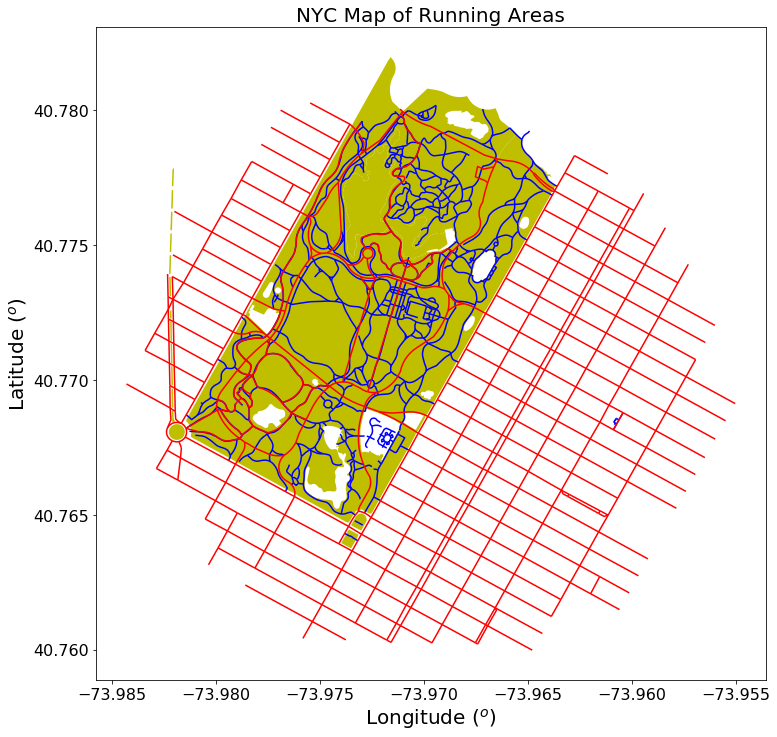

In [14]:
# plotting the selected data
fig, ax2 = pl.subplots(figsize=(12, 12))
borough_df1.plot(ax=ax2, color='y', label='x')  # roads
borough_df2.plot(ax=ax2, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax2, color='r', label='z')  # parks

# zoom on a specific region
#x_range = [-73.99, -73.95]
#y_range = [40.75, 40.8]
#x0 = pl.mean(x_range)
#y0 = pl.mean(y_range)
#dx = x_range[1] - x_range[0]
#dy = y_range[1] - y_range[0]
#dd = max([dx, dy]) / 2.
#pl.xlim([x0-dd, x0+dd])
#pl.ylim([y0-dd, y0+dd])
pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})

## Reformats Data

Converting the segment data into vertices and distance between them.

TO DO: Make sure all the segments are present. The "T-shape" ones may be missing.

In [15]:
def lon_lat_to_name(lon, lat):
    """
    converts lon (float) and lat (float) to 'lon_lat'
    """
    return "{0:f}_{1:f}".format(lon, lat)


def name_to_lon_lat(name):
    """
    Inverse of lon_lat_to_name
    """
    return float(name.split('_')[0]), float(name.split('_')[1])
print([borough_df3["geometry"].iloc[0]])


def get_tree_density(geom, df):
    """
    """

    x0 = geom.representative_point().x
    y0 = geom.representative_point().y
    x1 = geom.boundary[0].x
    y1 = geom.boundary[0].y
    x2 = geom.boundary[1].x
    y2 = geom.boundary[1].y
    r2 = ((x2-x1)**2 + (y2-y1)**2) / 4.
    
    inside = (df['longitude'] - x0)**2 + (df['latitude']-y0)**2 <= r2
    #print(inside.sum())
    #r^2 = (x-x0)^2 + (y-y0)^2
    
    return inside.sum()


def get_park_weight(geom, df):
    """
    """
    # calculates a weight based on park_area / (r_park - r)
    #d_start = pl.sqrt((geom.boundary[0].x - rad_to_deg(df['rep_x_rad']))**2 + (geom.boundary[0].y - rad_to_deg(df['rep_y_rad']))**2)
    #park_weight_start = (df['geometry'].area / d_start).sum()
    #d_end = pl.sqrt((geom.boundary[1].x - rad_to_deg(df['rep_x_rad']))**2 + (geom.boundary[1].y - rad_to_deg(df['rep_y_rad']))**2)
    #park_weight_end = (df['geometry'].area / d_end).sum()
    #return (park_weight_end - park_weight_start) / geom.length
    d_to_parks_squared = angular_distance(geom.representative_point().x, geom.representative_point().y, rad_to_deg(df['rep_x_rad']), rad_to_deg(df['rep_y_rad']))
    return pl.sqrt(1. / (1. / (d_to_parks_squared**2) ).sum() )

In [17]:
# extract the important information from the segments
data_for_df = {'lon_start': [], 'lat_start': [], 'lon_end': [], 'lat_end': [], 'distance':[], 'type': [],
               'connections_start': [], 'connections_end': [], 'name_start': [], 'name_end': [],
               'geometry': [], 'tree_number': [],}# 'park_weight': []}
for i in range(len(borough_df3.index)):
    data_for_df['lon_start'].append(borough_df3['geometry'].iloc[i].boundary[0].x)
    data_for_df['lat_start'].append(borough_df3['geometry'].iloc[i].boundary[0].y)
    data_for_df['lon_end'].append(borough_df3['geometry'].iloc[i].boundary[1].x)
    data_for_df['lat_end'].append(borough_df3['geometry'].iloc[i].boundary[1].y)
    data_for_df['distance'].append(borough_df3['geometry'].iloc[i].length)
    data_for_df['type'].append('street')
    data_for_df['connections_start'].append([])
    data_for_df['connections_end'].append([])
    data_for_df['name_start'].append(lon_lat_to_name(data_for_df['lon_start'][-1], data_for_df['lat_start'][-1]))
    data_for_df['name_end'].append(lon_lat_to_name(data_for_df['lon_end'][-1], data_for_df['lat_end'][-1]))
    data_for_df['geometry'].append(borough_df3['geometry'].iloc[i])
    data_for_df['tree_number'].append(get_tree_density(borough_df3['geometry'].iloc[i], borough_df4))
    #data_for_df['park_weight'].append(get_park_weight(borough_df3['geometry'].iloc[i], borough_df1))
for i in range(len(borough_df2.index)):
    data_for_df['lon_start'].append(borough_df2['geometry'].iloc[i].boundary[0].x)
    data_for_df['lat_start'].append(borough_df2['geometry'].iloc[i].boundary[0].y)
    data_for_df['lon_end'].append(borough_df2['geometry'].iloc[i].boundary[1].x)
    data_for_df['lat_end'].append(borough_df2['geometry'].iloc[i].boundary[1].y)
    data_for_df['distance'].append(borough_df2['geometry'].iloc[i].length)
    data_for_df['type'].append('sidewalk')
    data_for_df['connections_start'].append([])
    data_for_df['connections_end'].append([])
    data_for_df['name_start'].append(lon_lat_to_name(data_for_df['lon_start'][-1], data_for_df['lat_start'][-1]))
    data_for_df['name_end'].append(lon_lat_to_name(data_for_df['lon_end'][-1], data_for_df['lat_end'][-1]))
    data_for_df['geometry'].append(borough_df2['geometry'].iloc[i])
    data_for_df['tree_number'].append(get_tree_density(borough_df2['geometry'].iloc[i], borough_df4))
    #data_for_df['park_weight'].append(get_park_weight(borough_df2['geometry'].iloc[i], borough_df1))

## Make Connections between vertices

In [19]:
index_list = [5, 87, 149]  # a few segments to help debuging
for i in range(len(data_for_df['lon_start'])):
    for j in range(i+1, len(data_for_df['lon_start'])):
#for k in range(len(index_list)):
#    for kk in range(k+1, len(index_list)):
#        i = index_list[k]
#        j = index_list[kk]
        if data_for_df["lon_start"][i] == data_for_df["lon_start"][j] and data_for_df["lat_start"][i] == data_for_df["lat_start"][j]:
            #print('start-start')
            data_for_df['connections_start'][i].append(j)
            data_for_df['connections_start'][j].append(i)
        if data_for_df["lon_start"][i] == data_for_df["lon_end"][j] and data_for_df["lat_start"][i] == data_for_df["lat_end"][j]:
            #print('start-end')
            data_for_df['connections_start'][i].append(j)
            data_for_df['connections_end'][j].append(i)
        if data_for_df["lon_end"][i] == data_for_df["lon_start"][j] and data_for_df["lat_end"][i] == data_for_df["lat_start"][j]:
            #print('end-start')
            data_for_df['connections_end'][i].append(j)
            data_for_df['connections_start'][j].append(i)
        if data_for_df["lon_end"][i] == data_for_df["lon_end"][j] and data_for_df["lat_end"][i] == data_for_df["lat_end"][j]:
            #print('end-end')
            data_for_df['connections_end'][i].append(j)
            data_for_df['connections_end'][j].append(i)
#pl.array(data_for_df["connections_start"])[index_list]

In [20]:
def convert_segments_to_vertex(data):
    """
    Given the list of segments and their connections, provides vertex-to-vertex information
    """
    vertices = {'vertex_start': [], 'vertex_end': [], 'distance': [], 'type': [], 'geometry': [], 'tree_number': [],}
                #'park_weight': []}
    
    # loop over all the segments
    for i in range(len(data['type'])):
        # loop over the 2 extremities of each segment
        for which in ['start', 'end']:
            name1 = lon_lat_to_name(data['lon_'+which][i], data['lat_'+which][i])

            # loop over the connected segments
            for j in data['connections_'+which][i]:

                # find the vertices who are the same to identify which distance to keep
                if data['name_start'][j] == name1:
                    name2 = data['name_end'][j]
                elif data['name_end'][j] == name1:
                    name2 = data['name_start'][j]
                else:
                    raise ValueError('Problem!!!')
                
                is_defined = len(pl.where((pl.array(vertices["vertex_start"]) == name1) & (pl.array(vertices['vertex_end']) == name2))[0])
                #if len(vertices['geometry']) in [1246]:#, 0, 1387]:
                #    print('  ', 0, vertices['vertex_start'][0], vertices['vertex_end'][0])
                #    print(len(vertices['geometry']), name1, name2, is_defined)
                #    print(pl.array(vertices["vertex_start"]) == name1)
                # stores the path informations
                if not is_defined:
                    vertices['vertex_start'].append(name1)
                    vertices['vertex_end'].append(name2)
                    vertices['distance'].append(data['distance'][j])
                    vertices['tree_number'].append(data['tree_number'][j])
                    vertices['type'].append(data['type'][j])
                    vertices['geometry'].append(data['geometry'][j])
                    #vertices['park_weight'].append(data['park_weight'][j])
### do I have all paths?
    return vertices
    

In [21]:
#print(len(vertex_data['vertex_start']))
vertex_data = convert_segments_to_vertex(data_for_df)
for i in [   0, 1246, 1387]:
    print(vertex_data['vertex_start'][i], vertex_data['vertex_end'][i])
# vertex_data
#data_for_df
#vertex_data['park_weight']

/home/aubin/anaconda3/envs/insight/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-73.961110_40.769064 -73.962704_40.769739
-73.974838_40.768111 -73.974812_40.768128
-73.971590_40.770291 -73.971590_40.770522


## Write DataFrame to File

In [22]:
new_df = pd.DataFrame(data_for_df, columns=['lon_start', 'lat_start', 'lon_end', 'lat_end', 'distance', 'type', 'connections_start', 'connections_end'])
new_df.to_csv("selected_data_segments.csv")
print(len(new_df.index))
new_df.iloc[index_list]
#new_df.head()

1295


,lon_start,lat_start,lon_end,lat_end,distance,type,connections_start,connections_end
5,-73.976458,40.775533,-73.975955,40.776220,0.000851,street,"[87, 149]","[68, 88, 185]"
87,-73.976912,40.774909,-73.976458,40.775533,0.000771,street,"[468, 569]","[5, 149]"
149,-73.979287,40.776725,-73.976458,40.775533,0.003070,street,"[493, 536]","[5, 87]"


In [23]:
new_df2 = pd.DataFrame(vertex_data, columns=['vertex_start', 'vertex_end', 'distance', 'type', 'geometry',
                                             'tree_number'])#, 'park_weight'])
new_df2.to_csv("selected_data_vertices.csv")
print(len(new_df2.index))
new_df2.head()

2352


,vertex_start,vertex_end,distance,type,geometry,tree_number
0,-73.961110_40.769064,-73.962704_40.769739,0.001731,street,(LINESTRING (-73.96270392604585 40.76973878323...,40
1,-73.961110_40.769064,-73.960429_40.768784,0.000737,street,(LINESTRING (-73.96110997058013 40.76906440780...,14
2,-73.961110_40.769064,-73.961548_40.768432,0.000770,street,(LINESTRING (-73.96154785584113 40.76843158184...,14
3,-73.960602_40.769749,-73.960110_40.770432,0.000842,street,(LINESTRING (-73.96060180637529 40.76974918670...,15
4,-73.960602_40.769749,-73.958365_40.768798,0.002430,street,(LINESTRING (-73.96060180637529 40.76974918670...,84


## Some Functions for Debugging

In [24]:
def get_closest_point_to(lon0, lat0, intersection_list):
    """
    from a list of intersections (['lon_lat', ...]), returns the closest point to (lon, lat)
    Assumes all angles in degrees
    """
    locations = {'lon': [], 'lat': [], 'd': []}
    for name_ in intersection_list:
        lon, lat = name_to_lon_lat(name_)
        locations['lon'].append(lon)
        locations['lat'].append(lat)
        locations['d'].append(angular_distance(deg_to_rad(lon0), deg_to_rad(lat0), deg_to_rad(lon), deg_to_rad(lat)))
    n = pl.argmin(pl.array(locations['d']))
    return intersection_list[n]

# Distance Minimizer Algorithm

Implementing Dijkstra's algorithm to minimize distance, but keeping the weights (distances) explicit

In [25]:
def get_angle(x1, y1, x2, y2):
    """
    returns the polar angle of point (x2, y2) with respect to (x1, y1) in rad
    """
    opp = y2 - y1
    adj = x2 - x1
    theta = pl.arctan2(opp, adj)
    #print('-', opp, adj, theta)
    return theta

In [26]:
"""
Initial code taken from https://gist.github.com/kachayev/5990802
"""
from collections import defaultdict
# from heapq import *
import heapq
import copy


def update_costs(object_, target_d, d_done, current_point, end_point):
    """
    updates the costs in the defaultdict
    
    object_ is g in the dijkstra function
    target_d is the length of the intended run
    d_done is the dictionary of lengths so far for the routes
    
    cost function: ((d_left - d0) / d0)^2 * cos(theta_between_pt_and end)
                   ( 1 - (d_left - d0) / d0)^2 * tree_density_normalized
    
    Right now, sets all to 0
    """
#    print('Updating cost')
    #print(d_done)
    lon_end, lat_end = name_to_lon_lat(end_point)
    lon_current, lat_current = name_to_lon_lat(current_point)
    theta_end = get_angle(lon_current, lat_current, lon_end, lat_end)
    for key_ in [current_point]:#object_.keys():
    #for key_ in object_.keys():
        for i in range(len(object_[key_])):
            temp = list(object_[key_][i])
            #print(temp)
            lon, lat = name_to_lon_lat(object_[key_][i][1])
            # angular distance to end
            d = angular_distance(lon_end, lat_end, lon, lat)
            # cost function
            new_dist = temp[2]['distance'] + d_done[current_point]
            theta_pt = get_angle(lon_current, lat_current, lon, lat)
            #print(lon_current, lat_current, lon, lat, theta_end, theta_pt)
            theta_diff = theta_end - theta_pt
            #if key_ in ['-73.967727_40.762852', '-73.966813_40.764105', '-73.965670_40.762805', '-73.968783_40.764113']:
#            if key_ == '-73.967271_40.763480':
#                print(key_, object_[key_][i][1], rad_to_deg(theta_end), rad_to_deg(theta_pt), rad_to_deg(theta_diff))
            
            # cost function increases as run ends and is directed towards the end point
            if new_dist < target_d:
                r_factor = (target_d - new_dist) / target_d  # should be between 0 (start, new_dist=0) and 1 (end, new_dist=target_d)
            else:
                r_factor = 1.
            cost_terms = [(1. - r_factor)**2 * ((1. + pl.cos(pl.pi+theta_diff))/2.)**2]
            cost_terms.append((r_factor)**2 * (temp[2]['tree_density_weight'])**2)
            cost_terms.append((r_factor)**2 * temp[2]['park_weight']**2)
#            if key_ in ['-73.967727_40.762852', '-73.966813_40.764105', '-73.965670_40.762805', '-73.968783_40.764113']:
            if current_point == '-73.967271_40.763480':
                print(key_, object_[key_][i][1], i)
                print(pl.array(cost_terms)/pl.sum(cost_terms) * 100.)
                print(r_factor, rad_to_deg(theta_diff))
                print(cost_terms)
                print(pl.sum(cost_terms))
                print()
            temp[0] = copy.deepcopy(pl.sum(cost_terms))
            object_[key_][i] = temp
            #a+1
#    print('Done')
    return object_
    
    
def dijkstra(edges, start_label, final_label, target_distance):
    """
    edges is a list of ('pt1_label', 'pt2_label', cost), cost is typically distance
    start_label is the start point
    end_label is the final point
    """
    g = defaultdict(list)
    for label1, label2, cost_segment, info in edges:
        g[label1].append((cost_segment, label2, info))

    q, seen, mins_cost, calc_dists = [(0, start_label, (), 0)], set(), {start_label: 0}, {start_label: 0}
    g = update_costs(g, target_distance, calc_dists, start_label, final_label)
#    print(q)
#    print(start_label)
#    print(g[start_label])
#    return

    while q:
        # get a new vertex to visit
        temp = heapq.heappop(q)
        (cost, v1, path, dist) = temp
        #print('***', temp)
        #print('q', q, v1)

        # do not revisit vertex
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            
            # if arrived to last vertex, done
            if v1 == final_label:
                return (cost, path, dist)

            g = update_costs(g, target_distance, calc_dists, v1, final_label)
            for c, v2, info_ in g.get(v1, ()):
                
                # do not repeat visited vertex
                if v2 in seen:
                    continue
                
                prev_cost = mins_cost.get(v2, None)
                prev_dist = calc_dists.get(v2, None)
                new_cost = cost + c
                new_d = dist + info_['distance']
                if prev_cost is None or new_cost < prev_cost:
                    mins_cost[v2] = new_cost
                    calc_dists[v2] = new_d
                    heapq.heappush(q, (new_cost, v2, path, new_d))
        #return

    return float("inf")

#if __name__ == "__main__":
if False:
    # the 4th column is kept track of, but not minimized on
    edges = [
        ("A", "B", 1, 7),
        ("A", "D", 1, 5),
        ("B", "C", 1, 8),
        ("B", "D", 1, 9),
        ("B", "E", 1, 7),
        ("C", "E", 1, 5),
        ("D", "E", 1, 15),
        ("D", "F", 1, 6),
        ("E", "F", 1, 8),
        ("E", "G", 1, 9),
        ("F", "G", 1, 11)
    ]
    """
    edges = [
        ("A", "B", 7, 3.5),
        ("A", "D", 5, 2.5),
        ("B", "C", 8, 4.0),
        ("B", "D", 9, 4.5),
        ("B", "E", 7, 3.5),
        ("C", "E", 5, 2.5),
        ("D", "E", 15, 7.5),
        ("D", "F", 6, 3.0),
        ("E", "F", 8, 4.0),
        ("E", "G", 9, 4.5),
        ("F", "G", 11, 5.5)
    ]
    """
    """
    edges = [
        ("A", "B", 7),
        ("A", "D", 5),
        ("B", "C", 8),
        ("B", "D", 9),
        ("B", "E", 7),
        ("C", "E", 5),
        ("D", "E", 15),
        ("D", "F", 6),
        ("E", "F", 8),
        ("E", "G", 9),
        ("F", "G", 11)
    ]
    """

    print("=== Dijkstra ===")
    #print(edges)
    print("A -> E:")
    print(dijkstra(edges, "A", "E", 30))
    #print("F -> G:")
    #print(dijkstra(edges, "F", "G"))

In [27]:
# list of all possible intersections
intersection_names = list(set(list(new_df2['vertex_start'].values) + list(new_df2['vertex_end'].values)))

#pt1 = get_closest_point_to(-73.978, 40.778, intersection_names)
#pt2 = get_closest_point_to(-73.967, 40.767, intersection_names)
pt1 = get_closest_point_to(-73.967, 40.763, intersection_names)
pt2 = get_closest_point_to(-73.963, 40.772, intersection_names)
#pt2 = get_closest_point_to(-73.966, 40.765, intersection_names)

start_point = pt1
end_point = pt2
print(pt1, pt2)

target_dist_deg = 0.011  # shortest distance east of Central Park
target_dist_deg += 0.005

-73.967271_40.763480 -73.963214_40.771740


In [28]:
def define_park_weight(df1, df2, target_d):
    """
    """
    ret = []
    for i in range(len(df1.index)):
        # mean location of the segment
        lon1, lat1 = name_to_lon_lat(df1['vertex_start'].iloc[i])
        lon2, lat2 = name_to_lon_lat(df1['vertex_end'].iloc[i])
        lon = pl.mean([lon1, lon2])
        lat = pl.mean([lat1, lat2])
        
        # distance park - segment
        d_to_parks = angular_distance(lon, lat, rad_to_deg(df2['rep_x_rad']), rad_to_deg(df2['rep_y_rad']))

        # weight is quadratic from the park with value of 1 at target distance with 0 at park
        weight = (d_to_parks / target_d)**0.5#**2
        # select closest park
        weight = min(weight)
        # calue is topped to 1
        if weight > 1.:
            weight = 1.
        ret.append(weight)
    return ret

(array([  25.,  266.,  686.,  613.,  200.,  185.,  140.,  103.,   81.,   53.]),
 array([ 0.04513729,  0.12776431,  0.21039133,  0.29301835,  0.37564537,
         0.45827239,  0.54089941,  0.62352643,  0.70615345,  0.78878047,
         0.87140749]),
 <a list of 10 Patch objects>)

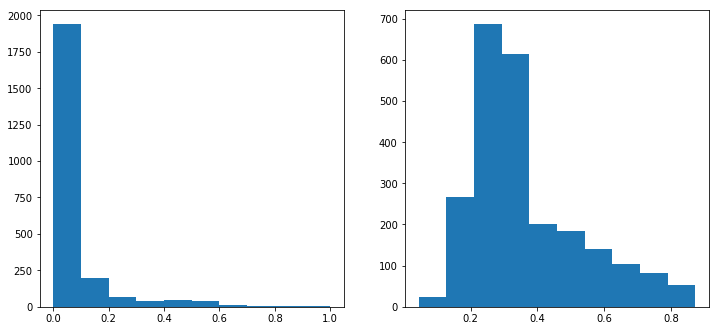

In [29]:
# tree_density = new_df2['tree_number'] / new_df2['distance']
tree_density_norm = new_df2['tree_number'] / max(new_df2['tree_number'])
#tree_density_norm /= max(tree_density)
#tree_density_norm = (tree_density - tree_density.mean()) / pl.std(tree_density)
# park_grad_norm = (new_df2['park_weight'] - new_df2['park_weight'].mean()) / new_df2['park_weight'].std()

#std = pl.std(new_df2['park_weight'])
#mean = pl.mean(new_df2['park_weight'])
#park_rel_dist = (new_df2['park_weight'] - mean) / std
#d0 = (target_dist_deg/2. - mean) / std / 2.
#park_rel_dist_norm = (park_rel_dist - d0) / (d0)

park_weight = define_park_weight(new_df2, borough_df1, target_dist_deg)
#bins = pl.arange(-10., 10., 0.1)
#pl.hist(tree_density_norm, bins=bins)
#pl.hist(10.*park_grad_norm, bins=bins)
#pl.hist(park_rel_dist)
#new_df2['park_weight']

pl.figure(figsize=(12, 12))
pl.subplot(221)
pl.hist(tree_density_norm)
pl.subplot(222)
pl.hist(park_weight)

In [30]:


edges = []
for i in range(len(new_df2.index)):
    # distance - shortest path
    edges.append((new_df2['vertex_start'].iloc[i],  # starting point
                  new_df2['vertex_end'].iloc[i],  # end point
                  0.,  # cost, updated automatically
                  {'distance': new_df2['distance'].iloc[i],  # distance of segment
                   'tree_density_weight': 1. - tree_density_norm.iloc[i],  # average tree density on the segment
                   'park_weight': park_weight[i],  # normarlized park gradient
                  }
                ))
    # weight is longitude -> West is prefered to East
    # edges.append((new_df2['vertex_start'].iloc[i], new_df2['vertex_end'].iloc[i],
    #               pl.mean([float(new_df2['vertex_start'].iloc[i].split('_')[0]), float(new_df2['vertex_end'].iloc[i].split('_')[0])])))
    # weight is -longitude -> East is prefered to West
    # edges.append((new_df2['vertex_start'].iloc[i], new_df2['vertex_end'].iloc[i],
    #               -pl.mean([float(new_df2['vertex_start'].iloc[i].split('_')[0]), float(new_df2['vertex_end'].iloc[i].split('_')[0])])))

xxx = dijkstra(edges, start_point, end_point, target_dist_deg)
print(xxx)

-73.967271_40.763480 -73.967727_40.762852 0
[  0.20496924  70.72769293  29.06733784]
0.951472232632 189.825423831
[0.0023205291925020416, 0.80073322200921326, 0.32908161029512556]
1.1321353615

-73.967271_40.763480 -73.966813_40.764105 1
[  1.21472310e-05   6.97719117e+01   3.02280761e+01]
0.951573229373 10.0754340927
[1.3943657589581717e-07, 0.80090322326644003, 0.34698438071979315]
1.14788774342

-73.967271_40.763480 -73.965670_40.762805 2
[  0.23083982  69.96664022  29.80251996]
0.891352696544 86.7023200156
[0.0026213129844557112, 0.79450962963678751, 0.33842398349555186]
1.13555492612

-73.967271_40.763480 -73.968783_40.764113 3
[  0.38780946  65.42352296  34.18866759]
0.897557822895 -93.4418653285
[0.0029480757597841198, 0.49734089539910448, 0.25989769093380494]
0.760186662093

-73.967271_40.763480 -73.967727_40.762852 0
[  0.20496924  70.72769293  29.06733784]
0.951472232632 189.825423831
[0.0023205291925020416, 0.80073322200921326, 0.32908161029512556]
1.1321353615

-73.967271_4

[401, 125, 1059, 733, 46, 1112, 556, 884, 377, 729, 27, 843, 935, 638, 649]
Total distance is: 0.014349 degrees, the taget was 0.016000 degrees


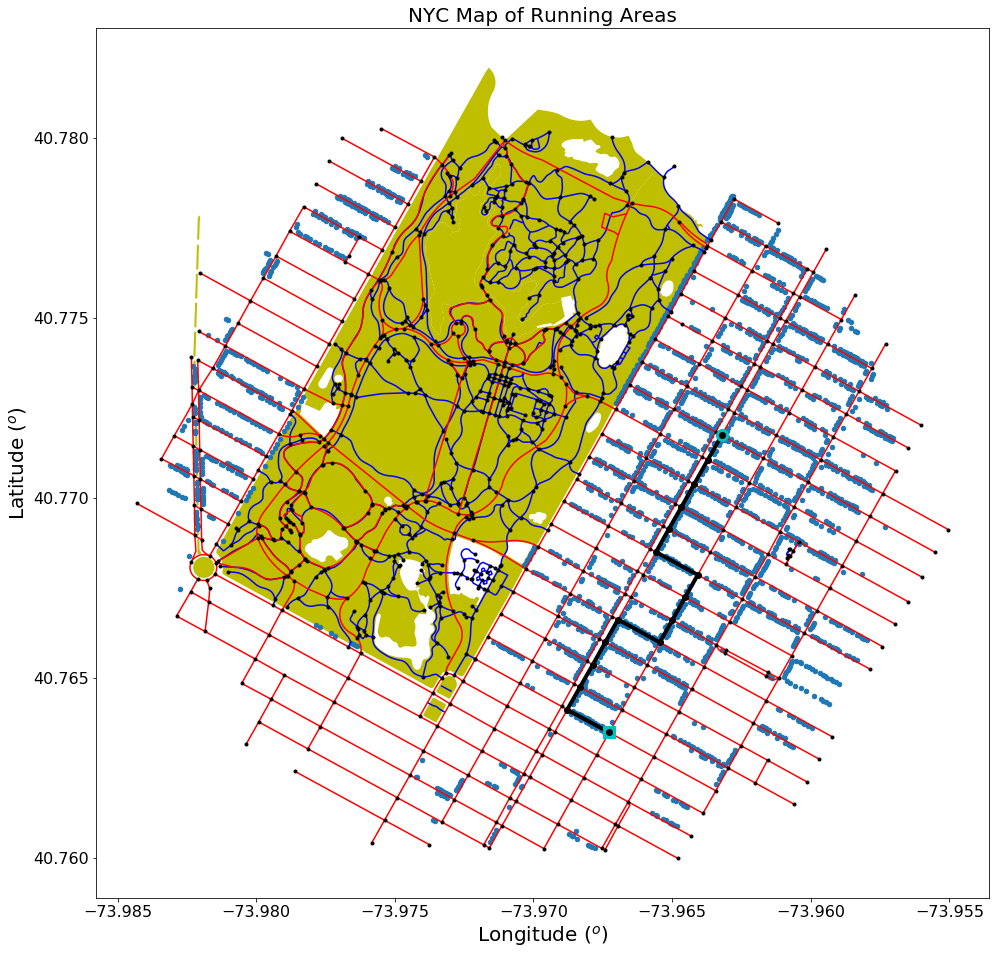

In [31]:
# 73.966813_40.764105
# plotting the selected data
fig, ax2 = pl.subplots(figsize=(16, 16))
borough_df1.plot(ax=ax2, color='y', label='x')  # roads
borough_df2.plot(ax=ax2, color='b', label='y')  # sidewalks
borough_df3.plot(ax=ax2, color='r', label='z')  # parks
borough_df4.plot('longitude', 'latitude', kind='scatter', ax=ax2)

# black dot on all intersections
for i in intersection_names:
    lon, lat = name_to_lon_lat(i)
    pl.plot(lon, lat, '.k')

# plots starting and end point
lon_start, lat_start = name_to_lon_lat(start_point)
pl.plot(lon_start, lat_start, 'sc', markersize=12)
lon_end, lat_end = name_to_lon_lat(end_point)
pl.plot(lon_end, lat_end, 'oc', markersize=12)


# plot the route (straight lines instead of actual geometry)
import copy
xx = copy.deepcopy(xxx[1])
prev_pt = None
path_indices = []
try:
    while True:
        pl.plot(float(xx[0].split('_')[0]), float(xx[0].split('_')[1]), 'ok')
        if prev_pt is not None:
            ind = pl.where((new_df2["vertex_start"] == prev_pt) & (new_df2['vertex_end'] == xx[0]))[0]
            if len(ind) > 1:
                print('problem with selecting path', ind)
            path_indices.append(ind[0])
            
        prev_pt = copy.deepcopy(xx[0])
        xx = copy.deepcopy(xx[1])
except IndexError:
    pass

pl.xlabel('Longitude ($^o$)', fontsize=20)
pl.ylabel('Latitude ($^o$)', fontsize=20)
pl.xticks(fontsize=16)
pl.yticks(fontsize=16)
pl.title('NYC Map of Running Areas', fontsize=20)
#pl.legend(['roads', 'sidewalks', 'parks'], loc=2, prop={'size': 14})

# make sure I have all the routes
new_gdf2 = gpd.GeoDataFrame(new_df2)
print(path_indices)
new_gdf2_path = new_gdf2.iloc[pl.array(path_indices)]
new_gdf2_path.plot(ax=ax2, color='k', linewidth=4)
# new_gdf2.plot(ax=ax2, color='w')
new_gdf2_path.head()

print('Total distance is: {0:f} degrees, the taget was {1:f} degrees'.format(new_gdf2_path["distance"].sum(), target_dist_deg))